# Resampling

The next idea I would like to demonstrate is resampling. This is a method of using a dataset to simmulate the random sampling process on the population in order to obtain estimates for a statistic and its possible varriation. You will see that it is a process that is designed to perform well with larger samples, though truthfully it yields valid results (though with caveats) in any case. It cannot however fix a sampling process that is flawed.

---

## Bootstrapping

Is the specific case of rebuilding a sample of exactly the same size as the original through resampling with replacement.

## Procedure

The procedure is to build a new sample by sampling from the dataset with replacement. One then computes the statistic of interest from the new sample and records the value. This process is then repeated multiple times. The result range of computed values forms an analogue of the confidence interval, and one can then reproduce hypothesis tests as well. 

## Simulating Data

A Big issue with educational (and other types of data) is that it is often protected under stringent protocols. A method developed by the Health Insurance industry is effective in creating a data set that merely simmulates the original dataset and in particular does not include the record of any indvidual and so can be used in ways that the original data could not be. One can do this by resampling with replacement from the original data forcing it to fit the parameters of a model to preserve what you think would be interesting features (covariances for instance). 

It is primarily a tool for when the code for a study is in development allowing one to study the analysis process and tools without having to be as careful with the protected data, with the idea that after things are developed we would then run the code for real on the protected data to obtain the final parameters and models.



In [2]:
penguins = read.csv("Datasets/penguins_lter.csv")
gentoo = penguins[penguins[,3]=='Gentoo penguin (Pygoscelis papua)',]
gentoo_flipper = na.omit(gentoo[,12])
# Note I had to add an na.omit

length(gentoo_flipper)

[1] 123

In [12]:
# Let's bootstrap this dataset a bunch of times and compute the mean each time:

data = c()
for (i in 1:1000) { 
  temp = sample(gentoo_flipper, 123, replace = TRUE)
  data = c(data, min(temp))
}

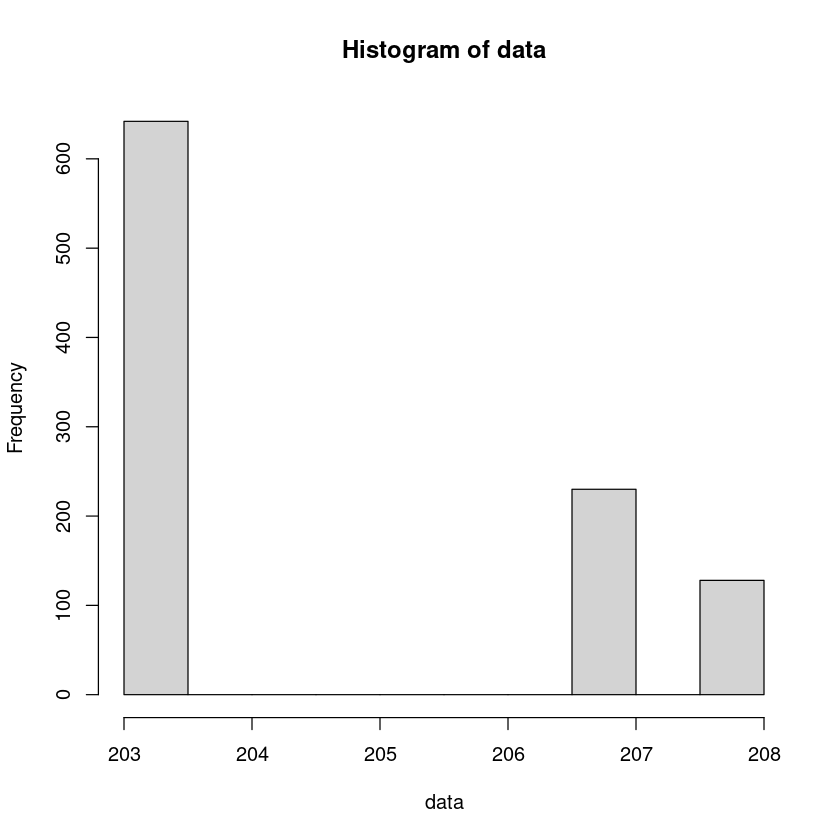

In [13]:
hist(data)

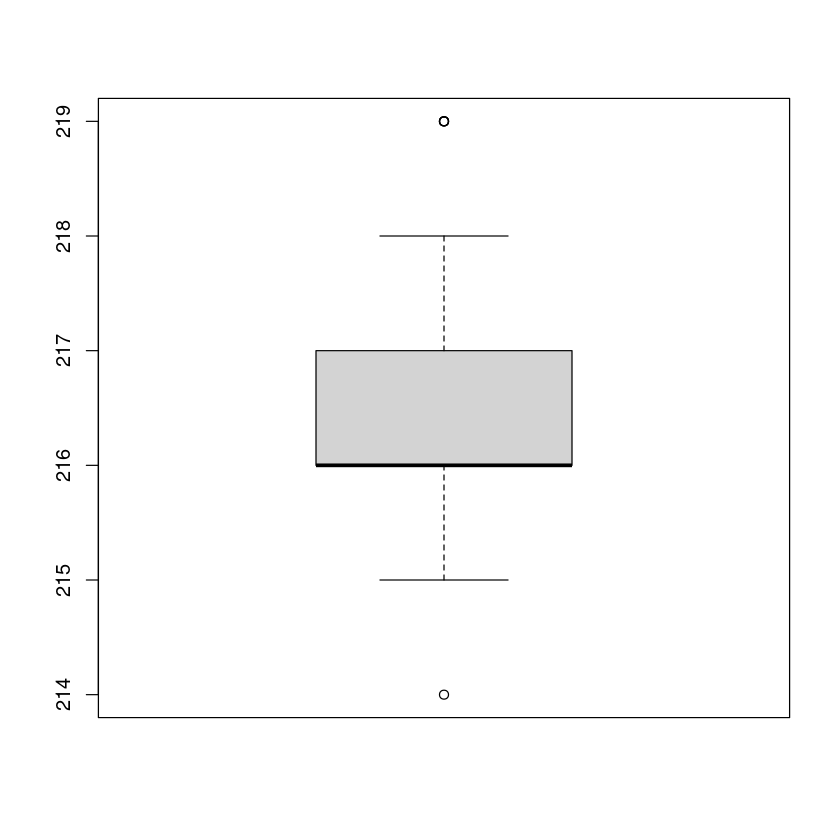

In [11]:
boxplot(data)

# The Datascience Modeling Process

Let's return to the classification of penguins problem. A problem confronting us is to choose a model that gives the *best* prediction of the species of penguins from the inputs that we can manage. More than that, what we want to understand about the model we decide on is what we expect its error to be. 

Note the danger:  As we increase the complexity of our model we obtain a result which adapts more to the training data. However the training data began as a random sample from a population - and so it contains irreducible errors caused by factors we do not (and in most cases cannot hope to) know.  If our model moves too closely to the training data, it may be responding to these errors rather than actual structure in the population - and we would expect this to then lead to a higher error rate when the model is applied to data it has never seen: the testing set or even worse, new observations. 

This is called **Overfitting**. 

Accordingly, much of our effort is going to go into overfitting. We will control for overfitting by repeatedly in the exploration phase of our analysis applying the models we have develop to new testing data that the model has not yet seen. In real applications, with *plenty* of data this process might be nested in multiple layers with a final testing set that is reserved until the final model has been selected and trained. 

The process of training and testing our model with multiple slices of our dataset is called **Crossvalidation**. And the goal is to find a model that captures true features in the data, avoids the overfitting that arises from responding to irreducible errors in the dataset, and to have a good estimate on the error and its varriation we expect from the final model. 

## Ethics

Note that how much effort one actually puts into this crossvalidation process would be determined by the ethical consideration of how likely errors seem to be, and on what the consequences for errors are. There is a big difference between us playing around with a penguin dataset, and us working for a university on student success data, financial data, or health data. 

## Cross Validation

There are lots of ways to do this. However a common one is to divide the data set randomly into 5 equal size pieces. We will then train our model on four of these pieces using the fifth one as a testing set. We can then repeate that with the same model and parameters five times obtaining an error estimate each time.

This will give us five estimates on the error produced by training the model with these parameters on a random training set when the model is applied to data it has not seen. Each individual data point is used four times as a training value and once as a testing value. 

In [14]:
# we need to remove the rows with missing data; and also pair the data down to just the values we will use
data = penguins[,c(3, 12,11)]
data = na.omit(data)
data$Species = as.factor(data$Species)   # we are going to use decision trees below, and for them the output column needs to be a factor and the inputs numerical or factors.
head(data)

,Species,Flipper.Length..mm.,Culmen.Depth..mm.
,<fct>,<int>,<dbl>
1,Adelie Penguin (Pygoscelis adeliae),181,18.7
2,Adelie Penguin (Pygoscelis adeliae),186,17.4
3,Adelie Penguin (Pygoscelis adeliae),195,18.0
5,Adelie Penguin (Pygoscelis adeliae),193,19.3
6,Adelie Penguin (Pygoscelis adeliae),190,20.6
7,Adelie Penguin (Pygoscelis adeliae),181,17.8


In [15]:
x = sample(nrow(data), nrow(data) )   # Shuffle the row indexes
splits = split(x, as.integer((x - 1)/(nrow(data)*0.2)) )   # divide the row indexes up into 5 mostly equal sized pieces
shuffles = list()

for (i in 1:5) {
    shuffles[[i]] = sort(x[splits[[i]]])
}

In [17]:
shuffles[[1]]

[1]   7   9  14  19  22  23  28  30  36  38  40  41  42  69  70  72  73  84  88
[20]  92  98 101 105 116 119 121 127 132 134 149 150 156 162 163 165 175 177 183
[39] 198 200 206 211 212 214 219 221 227 232 237 240 243 252 259 261 272 274 278
[58] 279 287 301 302 304 307 308 314 326 327 332 338

In [18]:
test = list()
train = list()

for (i in 1:5) {
    test[[i]] = data[shuffles[[i]],]
    train[[i]] = data[-shuffles[[i]], ]
}

## K Nearest Neighbors Again

We can now test this with the k-nearest neighbors algorithm we met last week.

In [19]:
library(class)

In [22]:
out = c()

for (i in 1:5) { 
    pr = knn(train[[i]][,-1],test[[i]][,-1],cl=train[[i]][,1],k=5)
    out = c(out, sum(test[[i]][,1]!=pr)/length(test[[i]][,1]))
}


In [23]:
out
mean(out)
sd(out)

[1] 0.2318841 0.2205882 0.1739130 0.2058824 0.1911765

[1] 0.2046888

[1] 0.02304088

## Decision Trees

It's worth looking at some other models now as well. One of the simplest models we can build is called a decision tree. Decision trees are a list of rules to mkae our classification.

They are even easier to explain than the KNN algorithm. And we see examples of them all around us:  For example the placement mechanism UNC uses for our courses is a decision tree: https://www.unco.edu/nhs/mathematical-sciences/placement/results.aspx

which tries to classify students into their mathemaitcs courses.

In [2]:
penguins = read.csv("Datasets/penguins_lter.csv")

In [3]:
# we need to remove the rows with missing data; and also pair the data down to just the values we will use
data = penguins[,c(3, 12,11)]
data = na.omit(data)
data$Species = as.factor(data$Species)   # we are going to use decision trees below, and for them the output column needs to be a factor and the inputs numerical or factors.
head(data)

,Species,Flipper.Length..mm.,Culmen.Depth..mm.
,<fct>,<int>,<dbl>
1,Adelie Penguin (Pygoscelis adeliae),181,18.7
2,Adelie Penguin (Pygoscelis adeliae),186,17.4
3,Adelie Penguin (Pygoscelis adeliae),195,18.0
5,Adelie Penguin (Pygoscelis adeliae),193,19.3
6,Adelie Penguin (Pygoscelis adeliae),190,20.6
7,Adelie Penguin (Pygoscelis adeliae),181,17.8


In [4]:
library(tidyverse)
library(tree)
library(rpart)
library(rpart.plot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'tree':
  method     from
  print.tree cli 



In [7]:
x = sample(nrow(data), nrow(data) )   # Shuffle the row indexes
splits = split(x, as.integer((x - 1)/(nrow(data)*0.2)) )   # divide the row indexes up into 5 mostly equal sized pieces
shuffles = list()

for (i in 1:5) {
    shuffles[[i]] = sort(x[splits[[i]]])
}

In [8]:
test = list()
train = list()

for (i in 1:5) {
    test[[i]] = data[shuffles[[i]],]
    train[[i]] = data[-shuffles[[i]], ]
}

In [9]:
md <- rpart(Species ~ Flipper.Length..mm. + Culmen.Depth..mm., data=train[[1]] )
md

n= 273 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 273 148 Adelie Penguin (Pygoscelis adeliae) (0.457875458 0.201465201 0.340659341)  
   2) Flipper.Length..mm.< 206.5 175  52 Adelie Penguin (Pygoscelis adeliae) (0.702857143 0.291428571 0.005714286)  
     4) Flipper.Length..mm.< 192.5 96  15 Adelie Penguin (Pygoscelis adeliae) (0.843750000 0.156250000 0.000000000) *
     5) Flipper.Length..mm.>=192.5 79  37 Adelie Penguin (Pygoscelis adeliae) (0.531645570 0.455696203 0.012658228)  
      10) Flipper.Length..mm.< 200.5 63  25 Adelie Penguin (Pygoscelis adeliae) (0.603174603 0.396825397 0.000000000) *
      11) Flipper.Length..mm.>=200.5 16   5 Chinstrap penguin (Pygoscelis antarctica) (0.250000000 0.687500000 0.062500000) *
   3) Flipper.Length..mm.>=206.5 98   6 Gentoo penguin (Pygoscelis papua) (0.020408163 0.040816327 0.938775510)  
     6) Culmen.Depth..mm.>=17.2 8   4 Chinstrap penguin (Pygoscelis antarctica) (0.250000000 0.500000000 0.250000000)

In [10]:
pdf("plot_tree.pdf") 
rpart.plot(md, box.palette="RdBu", shadow.col="gray", nn=TRUE )
dev.off() 

png 
  2

## Testing accuracy

In [12]:
help(rpart.predict)

rpart.predict {rpart.plot},R Documentation
"object, newdata, type, na.action","Identical to the same arguments for predict.rpart. If both nn and rules are FALSE, the returned value is identical to predict.rpart."
nn,"If TRUE, return a data.frame with the predictions as usual but with an extra column showing the leaf node number for each prediction."
rules,"If TRUE, return a data.frame with the predictions as usual but with an extra column showing the rpart rule (as a string) for each prediction. It may be helpful to use options(width=1000) before printing this data.frame."
...,"Passed on to rpart.rules, for example clip.facs=TRUE."


## Plotting the Decision Boundaries

Let's use the bit of code we introduced in Week 1 to plot the prediction over the phase space to illustrate the decision boundaries.

## Cross Validation

Then implement the training and testing over the five partitions of the data to obtain our crossvalidated error estimates.



## Using more variables

Decision Trees have to huge advantages over other machine models we will learn about:  They are the simplest possible model from a mathematical point of view (there are actually some subtleties in how they are trained and in the parameters we could use on them) which means they are easy to explain to lay people.

There other advantage is that they are easy to visually represent even in cases with multiple variables.